## Name and ID
* Name: Lexi Shewchuk (ashewc01)
* ID: 1331654

## HW05 Code


You will complete the following notebook, as described in the PDF for Homework 05 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file and the two tree images (PDFs generated using `graphviz` within the code), to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135).

### Import required libraries.

In [1]:
import numpy as np
import pandas as pd

import sklearn.tree
import graphviz

## Decision Trees

You should start by computing the two heuristic values for the toy data described in the assignment handout. You should then load the two versions of the abalone data, compute the two heuristic values on features (for the simplified data), and then build decision trees for each set of data.

### 1 Compute both heuristics for toy data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [2]:
#          A                                       B
#        /   \                                   /   \
#    True     False                           True   False
#   100% O     33% O                         75% O     25% O
#   0%   X     67% X                         25% X     75% X
#       
# If A = True,  guess O                    If B = True,  guess O
#    A = False, guess X                       B = False, guess X
#
# correct:                                 correct:
#   A = True:  2/2                           B = True:  3/4
#   A = False: 4/6                           B = False: 3/4
# score = 6/8                              score = 6/8

# use to calculate score for ONE value in an attribute
# sum score_k for all values in the attribute
def score_k(c_0, c_1, c_2=0):
    score = 0
    percent_0 = c_0 / (c_0 + c_1 + c_2)
    percent_1 = c_1 / (c_0 + c_1 + c_2)
    percent_2 = c_2 / (c_0 + c_1 + c_2)
    if percent_0 == max(percent_0, percent_1, percent_2):
        score += c_0
    elif percent_1 == max(percent_0, percent_1, percent_2):
        score += c_1
    else:
        score += c_2
    return score

print('A: {}/{}'.format(score_k(2, 0) + score_k(2, 4), 8))
print('B: {}/{}'.format(score_k(3, 1) + score_k(1, 3), 8))

A: 6/8
B: 6/8


#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [3]:
import math

# calculates entropy of an attribute, given a list of probabilities for each value
def entropy(prob_list):
    sum = 0
    for i in range(len(prob_list)):
        if prob_list[i] == 0:
            prob_list[i] = 1
        sum += prob_list[i] * math.log(prob_list[i], 2)
    return -1 * sum

# caluclate one part of the remainder equation, for a given value
def remainder_at_k(c_0_total, c_0_k, c_1_total, c_1_k, c_2_total=0, c_2_k=0):
    k_total = c_0_k + c_1_k + c_2_k
    real_total = c_0_total + c_1_total + c_2_total
    return  (k_total / real_total) * entropy([c_0_k/k_total, c_1_k/k_total, c_2_k/k_total])

# caluculate gains
remainder_A = remainder_at_k(4, 2, 4, 0) + remainder_at_k(4, 2, 4, 4)
gain_A = entropy([0.5, 0.5]) - remainder_A

remainder_B = remainder_at_k(4, 3, 4, 1) + remainder_at_k(4, 1, 4, 3)
gain_B = entropy([0.5, 0.5]) - remainder_B

print('A:', gain_A)
print('B:', gain_B)

A: 0.31127812445913283
B: 0.18872187554086717


#### (c) Discussion of results.

The reason to evaluate each heuristic is to determine which feature is the most important, and thus should belong closer to the root of the decision tree. For the counting heuristic, Feature A and Feature B evaluate to the same score; that is, using the majority class from each feature as the classifier, both features give a score of 6/8. Meanwhile, the information-theoretic heuristic demonstrates that Feature A is more important than Feature B. This is likely because we stand to gain the most information based on the value of A; if A is true, we know with 100% certainty that the class of the data is O. No such absolute conclusions can be drawn by using the counting heuristic. While both metrics will give you homologous end results, by placing Feature A at the root, it's possible to avoid unnessecary computations.

### 2 Compute both heuristics for simplified abalone data.

In [4]:
x_train = pd.read_csv('data_abalone/x_train.csv')
y_train = pd.read_csv('data_abalone/y_train.csv')
x_test = pd.read_csv('data_abalone/x_test.csv')
y_test = pd.read_csv('data_abalone/y_test.csv')

small_x_train = pd.read_csv('data_abalone/small_binary_x_train.csv')
small_y_train = pd.read_csv('data_abalone/3class_y_train.csv')
small_x_test = pd.read_csv('data_abalone/small_binary_x_test.csv')
small_y_test = pd.read_csv('data_abalone/3class_y_test.csv')

#### (a) Compute the counting-based heuristic, and order the features by it.

In [5]:
# based on the most frequent classification given a feature value,
# classify the example

# start by figuring out the number of each class in a given feature value 
num_features = len(small_x_train.columns)
cols = list(small_x_train.columns)
f_c = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
for i in range(len(small_x_train)):
    for f in cols:
        if small_x_train.at[i, f] == 0 and small_y_train.at[i, 'rings'] == 0:      # feature 0, output 0
            f_c[cols.index(f)][0] += 1
        elif small_x_train.at[i, f] == 0 and small_y_train.at[i, 'rings'] == 1:    # feature 0, output 1
            f_c[cols.index(f)][1] += 1
        elif small_x_train.at[i, f] == 0 and small_y_train.at[i, 'rings'] == 2:    # feature 0, output 2
            f_c[cols.index(f)][2] += 1
        elif small_x_train.at[i, f] == 1 and small_y_train.at[i, 'rings'] == 0:    # feature 1, output 0
            f_c[cols.index(f)][3] += 1
        elif small_x_train.at[i, f] == 1 and small_y_train.at[i, 'rings'] == 1:    # feature 1, output 1
            f_c[cols.index(f)][4] += 1
        elif small_x_train.at[i, f] == 1 and small_y_train.at[i, 'rings'] == 2:    # feature 1, output 2
            f_c[cols.index(f)][5] += 1



# get the score for each value, then sort by that value
scores = {}
for f in cols:
    i = cols.index(f)
    scores[f] = score_k(f_c[i][0], f_c[i][1]) + score_k(f_c[i][2], f_c[i][3]) + score_k(f_c[i][4], f_c[i][5])
scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

# print values
for i in scores:
    print('{}: {}/{}'.format(i, scores[i], len(small_x_train)))

height_mm: 2818/3176
diam_mm: 2806/3176
length_mm: 2800/3176
is_male: 2308/3176


#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [6]:
# get the gain for each value, then sort by that value
data_size = len(small_y_train)
gain_dict = {}

class_counts = [0, 0, 0]

for i in range(len(small_y_train)):
    class_counts[small_y_train.at[i, 'rings']] += 1

for f in range(len(cols)):
    remainder_f = remainder_at_k(class_counts[0], f_c[f][0], class_counts[1], f_c[f][1], class_counts[2], f_c[f][2])
    gain_f = entropy([class_counts[0]/data_size, class_counts[1]/data_size, class_counts[2]/data_size]) - remainder_f
    gain_dict[cols[f]] = gain_f
gain_dict = dict(sorted(gain_dict.items(), key=lambda x: x[1], reverse=True))

# print values
for i in gain_dict:
    print('{}: {}'.format(i, gain_dict[i]))

height_mm: 0.7009894850999243
length_mm: 0.6948621592676095
diam_mm: 0.6948359821321415
is_male: 0.40121657477386385


### 3 Generate decision trees for full- and restricted-feature data

#### (a) Print accuracy values and generate tree images.

small data score TRAIN: 0.7326826196473551
small data score TEST:  0.722
big data score TRAIN:   1.0
big data score TEST:    0.18839999999999998


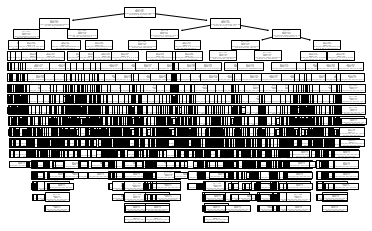

In [7]:
# get average score (average because of RandomState)
small_train_scores = list()
small_test_scores = list()
big_train_scores = list()
big_test_scores = list()
# big_scores_max_nodes_train = list()
# big_scores_max_nodes_test = list()

for rand in range(5):
    small_tree_classifier = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
    small_tree_classifier.fit(small_x_train, small_y_train)
    small_train_scores.append(small_tree_classifier.score(small_x_train, small_y_train))
    small_test_scores.append(small_tree_classifier.score(small_x_test, small_y_test))
      
    big_tree_classifier = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
    big_tree_classifier.fit(x_train, y_train)
    big_train_scores.append(big_tree_classifier.score(x_train, y_train))
    big_test_scores.append(big_tree_classifier.score(x_test, y_test))
    
    # big_tree_classifier_max_nodes = sklearn.tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=45)
    # big_tree_classifier_max_nodes.fit(x_train, y_train)
    # big_scores_max_nodes_train.append(big_tree_classifier_max_nodes.score(x_train, y_train))
    # big_scores_max_nodes_test.append(big_tree_classifier_max_nodes.score(x_test, y_test))
    
print('small data score TRAIN:', np.mean(small_train_scores))
print('small data score TEST: ', np.mean(small_test_scores))
print('big data score TRAIN:  ', np.mean(big_train_scores))
print('big data score TEST:   ', np.mean(big_test_scores))
# print('max node score TRAIN:  ', np.mean(big_scores_max_nodes_train))
# print('max node score TEST:   ', np.mean(big_scores_max_nodes_test))


sklearn.tree.plot_tree(small_tree_classifier);
graph_data = sklearn.tree.export_graphviz(small_tree_classifier, out_file=None, filled=True, rounded=True);
graph = graphviz.Source(graph_data);
graph.render('small-tree-classifier');

sklearn.tree.plot_tree(big_tree_classifier);
graph_data = sklearn.tree.export_graphviz(big_tree_classifier, out_file=None, filled=True, rounded=True);
graph = graphviz.Source(graph_data);
graph.render('big-tree-classifier');

# sklearn.tree.plot_tree(big_tree_classifier_max_nodes)
# graph_data = sklearn.tree.export_graphviz(big_tree_classifier_max_nodes, out_file=None, filled=True, rounded=True) 
# graph = graphviz.Source(graph_data)
# graph.render('max-node-tree-classifier');

#### (b) Discuss the results seen for the two trees

Looking at the simple, smaller tree generated from the binarized/ternarized data, it's easy to see how the classifier makes its decisions; firstly, it looks at X[3] (height) then at X[2] (diameter), then either X[1] (length) or X[0] (male). Depending on if these values are less than 0.5 (left branch) or not (right branch), the classifier goes down and arrives at its classification. Training and testing scores are almost identical -- 73% and 72%, respectively -- showing that this model is very dependable. The errors that it makes are primarily outliers -- abalone with similar features to other abalone, but have a different ring size group.
Meanwhile, the more complex model is, well, more complex. Because the values for each feature aren't discretized, the model is allowed to be as sensitive to values as it wants to be; there are no broad thresholds it must adhere to. As a result, the model has a literally perfect training score, which could be great, except that its performance on unseen testing data is horrendous -- less than 19%. While the training score seems impressive, this model is extraordinarily overfit, and isn't actually useful for predicting abalone ring count.
What's worth noting is that there are ways of reducing overfitting. Some that I investigated were max_leaf_nodes and min_impurity_decrease. By finding the best values for these hyperparamters, testing accuracy can be increased from ~19% to ~28%, which is fairly substantial, but with those regualarizations comes a decrease in training accuracy.